In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
from scipy.linalg import hankel
from scipy.stats import dirichlet, poisson
from scipy.special import factorial, logsumexp
import statsmodels.api as sm
import matplotx
from multiprocessing import Pool
from time import time
from tqdm import tqdm
import os
import torch
from torch import nn
from torch.utils.data import DataLoader

plt.style.use(matplotx.styles.aura["dark"])

/usr/people/ye9829/.conda/envs/mybase/envs/towers/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("test_data_acc_ind_492_0607.pickle", "rb") as handle:
    data = pickle.load(handle)
print(data.keys())
total_neurons = len(data["spikes"])
print(f"n_neurons: {total_neurons}")
print("n_trials: {}".format(data["choice"].size))

dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'spikes', 'timeSqueezedFR'])
n_neurons: 324
n_trials: 290


In [3]:
# constructing design matrix with all trials and all neurons
np.random.seed(0)
X_all = []
y_all = []
trial_indices = np.nonzero(data["currMaze"] > 0)[0]
print(f"number of trials: {trial_indices.size}")
filt_len = 30
sp_filt_len = 20
bin_size = 0.35
n_neurons = 20
neuron_idx = np.random.randint(0, total_neurons, size=n_neurons)
# neuron_idx = np.array([11, 12])
trial_id = (
    []
)  # this will keep track of each trial in the design matrix (since each trial spans multiple rows)
for i, neuron in enumerate(neuron_idx):
    X = []
    y = []

    for trial_idx in trial_indices:
        trial_start = data["trialStart"][trial_idx]
        trial_end = data["trialEnd"][trial_idx]
        trial_length = trial_end - trial_start

        keyframes = data["keyFrames"][trial_idx]
        keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
        lcue_times = data["cueOnset_L"][trial_idx]
        rcue_times = data["cueOnset_R"][trial_idx]

        spikes = data["spikes"][neuron]
        spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]

        bins = np.arange(0, trial_length, bin_size)
        bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

        binned_stimr, _ = np.histogram(rcue_times, bins)
        binned_stiml, _ = np.histogram(lcue_times, bins)
        binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)
        binned_spikes, _ = np.histogram(spikes - trial_start, bins)

        padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
        X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
        padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
        X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
        padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
        X_ev = hankel(padded_ev[: -filt_len + 1], padded_stiml[-filt_len:])

        padded_spikes = np.pad(
            binned_spikes[:-1], (sp_filt_len, 0), constant_values=(0, 0)
        )
        X_sp = hankel(padded_spikes[: -sp_filt_len + 1], padded_spikes[-sp_filt_len:])

        X.append(np.hstack((X_sr, X_sl, np.ones((X_sp.shape[0], 1)))))
        y.append(binned_spikes[:, np.newaxis])
        if i == 0:
            trial_id.append(trial_idx * np.ones(X_sr.shape[0]))

    X_all.append(np.vstack(X))
    y_all.append(np.vstack(y))

trial_id = np.concatenate(trial_id)
X_all = np.array(X_all)
y_all = np.array(y_all)
print(y_all.shape, X_all.shape)
neuron_idx

number of trials: 290
(20, 13238, 1) (20, 13238, 61)


array([172,  47, 117, 192, 323, 251, 195,   9, 211, 277, 242, 292,  87,
        70,  88, 314, 193,  39,  87, 174])

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features, n_neurons):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, n_neurons),
            nn.ReLU(),
        )

    def forward(self, x):
        # print(x)
        # x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out

    def train(self, x, y, epochs=1000):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-3)
        loss_fn = torch.nn.MSELoss()

        for i in range(epochs):
            pred = self.forward(x)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i % 10 == 0:
                print(f"epoch {i} loss = {loss.item()}")


X = np.vstack(X)
model = NeuralNetwork(X.shape[1], y_all.shape[0])
model.train(
    torch.tensor(X, dtype=torch.float32),
    torch.tensor(y_all.squeeze().T, dtype=torch.float32),
)

epoch 0 loss = 10.398453712463379
epoch 10 loss = 10.378352165222168
epoch 20 loss = 10.358281135559082
epoch 30 loss = 10.338234901428223
epoch 40 loss = 10.318206787109375
epoch 50 loss = 10.298189163208008
epoch 60 loss = 10.278176307678223
epoch 70 loss = 10.258162498474121
epoch 80 loss = 10.238138198852539
epoch 90 loss = 10.218103408813477
epoch 100 loss = 10.198042869567871
epoch 110 loss = 10.177957534790039
epoch 120 loss = 10.1578369140625
epoch 130 loss = 10.137674331665039
epoch 140 loss = 10.117466926574707
epoch 150 loss = 10.097203254699707
epoch 160 loss = 10.076878547668457
epoch 170 loss = 10.056485176086426
epoch 180 loss = 10.036017417907715
epoch 190 loss = 10.01546859741211
epoch 200 loss = 9.994833946228027
epoch 210 loss = 9.974102973937988
epoch 220 loss = 9.953271865844727
epoch 230 loss = 9.932331085205078
epoch 240 loss = 9.911274909973145
epoch 250 loss = 9.890094757080078
epoch 260 loss = 9.86877155303955
epoch 270 loss = 9.847311019897461
epoch 280 loss 

In [7]:
pred = model.forward(torch.tensor(X, dtype=torch.float32))
pred.shape

torch.Size([13238, 20])

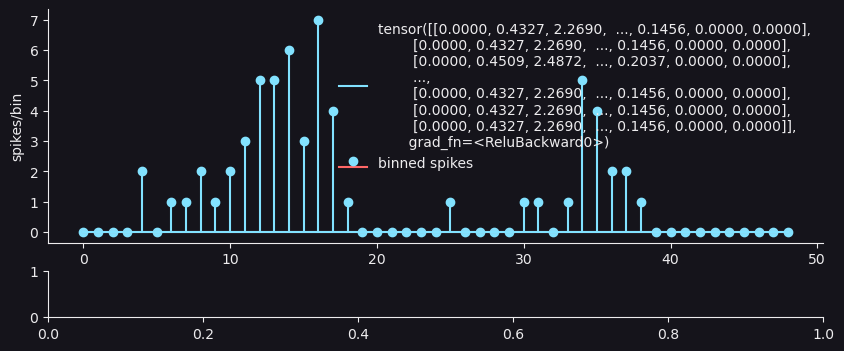

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={"height_ratios": [5, 1]})

sort_idx = np.argsort(
    data["nCues_RminusL"]
)  # ordered index of (lots of left cues) -> (lots of right cues)
plot_trial = sort_idx[-2]
neuron = 4
X_plot = X[trial_id == plot_trial]
# y_pred = np.exp(X_plot @ theta_init[:, neuron])
y_pred = pred[trial_id == plot_trial, neuron].detach().numpy()

# y_pred = np.exp(X_plot @ theta_post[:, :, neuron].T)

y_plot = y_all[neuron, trial_id == plot_trial]
axs[0].stem(y_plot, label="binned spikes")
axs[0].plot(y_pred, label=pred)
# trial_xticks(axs[0], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[0].set_ylabel("spikes/bin")
axs[0].legend()


# axs[1].plot(bin_centers, binned_stimr, color=colors[0], label="right towers")
# axs[1].plot(bin_centers, binned_stiml, color=colors[1], label="left towers")
# trial_xticks(axs[1], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
# axs[1].set_ylabel("# of towers")
# axs[1].set_title("Binned Stimulus")
# axs[1].legend()
# plt.tight_layout()
sns.despine()
# print(f"gamma for selected trial {np.exp(gamma[:, plot_trial])}")

In [23]:
y_pred.detach().numpy()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [25]:
y_pred.shape

torch.Size([49])